# Objetivo Geral do Projeto

Simular o desenvolvimento de um sistema de coleta de dados e avaliação com o objetivo de prever o valor de um imóvel com base em suas demais características.

# Pedidos do CEO (perguntas de negócio):
1. Realizar busca de imóveis no site www.portalimoveiscuritiba.com.br e salvar resultado em um ficheiro CSV.
2. Quais os imóveis disponíveis em Curitiba?
3. Destes imóveis, qual é o que possui mais quartos e qual tem mais espaços de garagem?
4. Quais são os imóveis mais caro e mais barato de Curitiba?
5. Criar uma classificação para os imóveis de Curitiba, separando-os em categorias proporcionais (baixo padrão/ alto padrão).
6. Criar um relatório ordenado pelo preço dos imóveis de Curitiba.
7. Criar uma classificação de acordo com a região/zona da cidade de Curitiba que o imóvel está localizado.
8. Desenvolver um sistema preditivo do preço do imóvel em função das características de quartos, garagens e região de Curitiba.

# Procedimentos para a solução:

- Web Scraping
- Análise Exploratória dos Dados
- Processamento dos Dados
- Modelo de Regressão
- Respostas para perguntas de negócio

# Parte 1: WEB SCRAPING

# Objetivo específico

Realizar processo de coleta de dados estruturados da web de maneira automatizada (web scraping) de site de imóveis residenciais de Curitiba (Brasil).

# Bibliotecas

In [2]:
from urllib.request import urlopen, urlretrieve, Request
from urllib.error import URLError, HTTPError
import urllib.request as urllib_request
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Accent')
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

# Conexão com o site

In [3]:
# atribuindo site para variável
url = "https://portalimoveiscuritiba.com.br/imoveis?nidtbxfin=1&nidtbxtpi=1&nidtagbac=&nidtbxloc="

# teste de erros
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36'}

try:
    req = Request(url, headers = headers)
    response = urlopen(req, timeout=20)
    print(response.read())

except HTTPError as e:
    print(e.status, e.reason)

except URLError as e:
    print(e.reason)

b'<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "https://www.w3.org/TR/html4/loose.dtd">\n<html>\n    <head>\n    <meta http-equiv="Content-Type" content="text/html; charset=UTF-8">\n    <meta name="viewport" content="width=device-width, initial-scale=1">\n        <meta property="og:type" content="website" />\n        <meta property="og:title" content="Portal Im\xc3\xb3veis Curitiba" />\n        <meta property="og:description" content="Portal im\xc3\xb3veis curitiba. Imobili\xc3\xa1rias em Curitiba e Regi\xc3\xa3o. Apartamentos e casas para alugar em curitiba. Procurando im\xc3\xb3veis em curitiba? Veja ofertas!" />\n        <meta property="og:url" content="https://portalimoveiscuritiba.com.br/imoveis?nidtbxfin=1&nidtbxtpi=1&nidtagbac=&nidtbxloc=" />\n        <meta property="og:image" content="https://portalimoveiscuritiba.com.br/images/screenshot-portal-2.png" />\n    <meta property="og:image:width" content="291" />\n    <meta property="og:image:height" content="167" 

A conexão foi estabelecida sem erros.

# Scraping

In [4]:
# obtendo dados da HTML
response = urlopen(url, timeout=20) 
html = response.read().decode('utf-8') 

# tratamento de dados da html: eliminar espaços entre as TAGs
html = " ".join(html.split()).replace('> <', '><')

# criação do objeto BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')
pages = int(soup.find('div', class_='pagerfanta').get_text().split()[-1].split('...')[-1])

# declarando variável cards que armazenará conteúdo do dataset
cards = []

# iterando todas as páginas do site
for i in range(pages):
    
    # obtendo o HTML
    response = urlopen('https://portalimoveiscuritiba.com.br/imoveis?nidtbxfin=1&nidtbxtpi=1&nidtagbac=&nidtbxloc=&page=' + str(i + 1))
    html = response.read().decode('utf-8')
    soup = BeautifulSoup(html, 'html.parser')
    
    # obtendo as TAGs de interesse: todos os imóveis anunciados
    ads = soup.find('div', class_="tl-filterOuter").findAll('div', class_="row")
    
    for ad in ads:
        card = {}

        # Valor
        card['price'] = ad.find('h3', {'class': 'price'}).getText()

        # Localização
        address = ad.find('span', {'class': 'address'}).getText().split(' - ')
        card['city'] = address[0].lower()
        card['neighborhood'] = address[-1].lower()
        
        # Quartos e Garagens
        info = ad.find('ul', {'class': 'tl-meta-listed'}).get_text().split()
        card['bedrooms'] = info[1]
        card['garage'] = info[-1]
        
        # Adicionando resultado à lista cards
        cards.append(card)    

# Ficheiro CSV

In [5]:
# criando um DataFrame com os resultados
df = pd.DataFrame(cards)

# tratando os dados: registros ausentes no site serão padronizados para None
df['bedrooms'][df['bedrooms'] == 'Garagens'] = np.nan
df['garage'][df['garage'] == 'Garagens'] = np.nan

In [6]:
# quantidade de cards obtidos 
len(cards)

2781

In [7]:
# quantidade de linhas e colunas do dataset
df.shape

(2781, 5)

In [8]:
# tratamento e conversão da coluna 'price'
df['price'] = df['price'].replace('[R\$\.\,]', '', regex=True).astype(float)

# cortando as casas decimais de valores 
df['price'] = df['price'] / 100

# transformando em inteiros
df['price'] = df['price'].astype(int)

In [9]:
# visualização do dataset
df

,price,city,neighborhood,bedrooms,garage
0,189000,araucária,iguaçu,2,1
1,310000,araucária,centro,2,1
2,194000,curitiba,santa cândida,2,1
3,3850000,curitiba,ecoville,4,4
4,2745000,curitiba,ecoville,3,4
...,...,...,...,...,...
2776,585000,curitiba,são francisco,2,2
2777,1050000,curitiba,água verde,3,2
2778,1271328,curitiba,mercês,3,2
2779,3350000,curitiba,cabral,4,5


In [10]:
# informações sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         2781 non-null   int32 
 1   city          2781 non-null   object
 2   neighborhood  2781 non-null   object
 3   bedrooms      2746 non-null   object
 4   garage        2654 non-null   object
dtypes: int32(1), object(4)
memory usage: 97.9+ KB


## Pedido 1. O ficheiro 'dataset_todos_imoveis.cvs' contém os imóveis disponíveis no site.

In [11]:
# salvando o dataset em um ficheiro CSV
df.to_csv('./dataset_todos_imoveis222.csv', sep=';', index = False, encoding = 'utf-8-sig')

# PARTE 2: ANÁLISE EXPLORATÓRIA

In [3]:
# carregando o dataset salvo
df = pd.read_csv('./dataset_todos_imoveis.csv', sep=';')

# visualização das primeiras linhas do dataset
df.head()

,price,city,neighborhood,bedrooms,garage
0,189000,araucária,iguaçu,2.0,1.0
1,310000,araucária,centro,2.0,1.0
2,194000,curitiba,santa cândida,2.0,1.0
3,3850000,curitiba,ecoville,4.0,4.0
4,2745000,curitiba,ecoville,3.0,4.0


In [4]:
# selecionando apenas imóveis de Curitiba
df.city.value_counts()

curitiba                 2375
são josé dos pinhais      188
araucária                 163
colombo                    24
pinhais                     8
fazenda rio grande          7
campo largo                 7
almirante tamandaré         4
piraquara                   2
quatro barras               1
contenda                    1
campina grande do sul       1
Name: city, dtype: int64

In [5]:
# removendo imóveis que não são de Curitiba
df = df.loc[lambda df: df['city'] == 'curitiba', :]

# contagem de imóveis de Curitiba 
df.city.value_counts()

curitiba    2375
Name: city, dtype: int64

# Tratamento dos dados nulos

In [6]:
# verificando dados nulos no dataframe
df.isnull().sum()

price            0
city             0
neighborhood     0
bedrooms        29
garage          98
dtype: int64

In [7]:
# criando um dataframe temporário sem linhas com quartos com valor nulo
df_temp = df[df['bedrooms'].notna()]

# média de quartos em dataframe temporário
bedrooms_mean = df_temp['bedrooms'].astype(int).mean()

# convertendo média para inteiros
bedrooms_mean = int(bedrooms_mean)
print(bedrooms_mean)

2


In [8]:
# preenchendo valores nulos de quartos com média do dataframe
df['bedrooms'].fillna(bedrooms_mean, inplace =True)

In [9]:
df.head()

,price,city,neighborhood,bedrooms,garage
2,194000,curitiba,santa cândida,2.0,1.0
3,3850000,curitiba,ecoville,4.0,4.0
4,2745000,curitiba,ecoville,3.0,4.0
5,3032000,curitiba,ecoville,3.0,4.0
6,1640000,curitiba,champagnat,3.0,3.0


In [10]:
df.isnull().sum()

price            0
city             0
neighborhood     0
bedrooms         0
garage          98
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2375 entries, 2 to 2780
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         2375 non-null   int64  
 1   city          2375 non-null   object 
 2   neighborhood  2375 non-null   object 
 3   bedrooms      2375 non-null   float64
 4   garage        2277 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 111.3+ KB


In [12]:
df['bedrooms'] = df['bedrooms'].astype(int)


In [13]:
# transformação da str 'garage' em float
df['garage'] = df['garage'].astype(float)

#observação de correlações
df.corr()

,price,bedrooms,garage
price,1.000000,0.021670,0.024353
bedrooms,0.021670,1.000000,0.598698
garage,0.024353,0.598698,1.000000


In [14]:
# calculando a taxa de proporção de espaços de garagem em função do número de quartos dos imóveis
garage_rate = df['garage'].sum()/df['bedrooms'].sum()

print('A taxa de garagens por quartos do dataset é:', garage_rate)

# utilizando a taxa para substituir valores nulos
print('Os valores nulos em garagem serão preenchidos em função do número de quartos do imóvel.')
df['garage'].fillna((df['bedrooms']*garage_rate).round(), inplace = True)

print('O número de valores nulos em df é:', df.isnull().sum().sum())

A taxa de garagens por quartos do dataset é: 0.6750931777669745
Os valores nulos em garagem serão preenchidos em função do número de quartos do imóvel.
O número de valores nulos em df é: 0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2375 entries, 2 to 2780
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         2375 non-null   int64  
 1   city          2375 non-null   object 
 2   neighborhood  2375 non-null   object 
 3   bedrooms      2375 non-null   int32  
 4   garage        2375 non-null   float64
dtypes: float64(1), int32(1), int64(1), object(2)
memory usage: 102.1+ KB


<AxesSubplot:xlabel='price'>

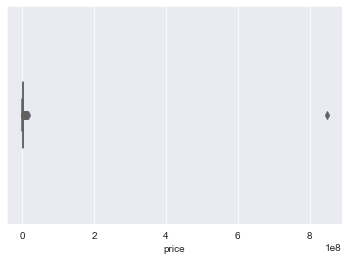

In [16]:
sns.boxplot(x='price',
            data=df,
            orient='h',
            width=0.3)

In [17]:
df['price'].describe().round()

count         2375.0
mean       1538531.0
std       17426822.0
min              0.0
25%         350000.0
50%         729568.0
75%        1350000.0
max      847515100.0
Name: price, dtype: float64

## Excluindo os outliers da variável dependente

In [18]:
# excluindo imóveis com preço igual a zero
df = df.drop(df[df.price == 0].index)

# excluindo o imóvel com preço muito acima do resto
df = df.drop(df[df.price > 800000000].index)

In [19]:
# organizando o index
df.reset_index(drop=True, inplace=True)
df.head()

,price,city,neighborhood,bedrooms,garage
0,194000,curitiba,santa cândida,2,1.0
1,3850000,curitiba,ecoville,4,4.0
2,2745000,curitiba,ecoville,3,4.0
3,3032000,curitiba,ecoville,3,4.0
4,1640000,curitiba,champagnat,3,3.0


<AxesSubplot:xlabel='price'>

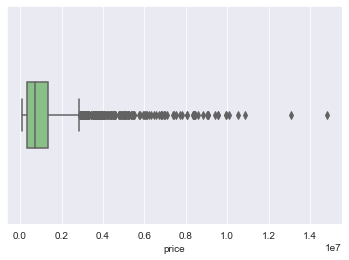

In [20]:
sns.boxplot(x='price',
            data=df,
            orient='h',
            width=0.3)

In [21]:
df.describe().round()

,price,bedrooms,garage
count,2366.0,2366.0,2366.0
mean,1186178.0,3.0,2.0
std,1451222.0,1.0,1.0
min,114950.0,0.0,0.0
25%,350000.0,2.0,1.0
50%,730000.0,3.0,2.0
75%,1350000.0,3.0,2.0
max,14795400.0,6.0,12.0


## Pedido 2. Quais os imóveis disponíveis em Curitiba?

In [22]:
# imóveis disponíveis em Curitiba
print('O dataset possui {} imóveis disponíveis em Curitiba'.format(len(df)))

O dataset possui 2366 imóveis disponíveis em Curitiba


## Pedido 3. Qual é o que possui mais quartos e qual tem mais espaços de garagem?

In [23]:
# imóvel com mais quartos
df[df['bedrooms'] == df['bedrooms'].max()]

,price,city,neighborhood,bedrooms,garage
483,1350000,curitiba,champagnat,6,5.0


In [24]:
# imóvel com mais espaços de garagem
df[df['garage'] == df['garage'].max()]

,price,city,neighborhood,bedrooms,garage
1857,617700,curitiba,mercês,2,12.0


In [25]:
print('Imóvel com maior número de quarto:', int(df['bedrooms'].max()), 'quartos.')
print('Imóvel com maior número de espaços de garagem:', int(df['garage'].max()), 'espaços.')

Imóvel com maior número de quarto: 6 quartos.
Imóvel com maior número de espaços de garagem: 12 espaços.


## Pedido 4. Quais são os imóveis mais caro e mais barato?

In [26]:
# imóvel mais caro
df[df['price'] == df['price'].max()]

,price,city,neighborhood,bedrooms,garage
1252,14795400,curitiba,água verde,3,6.0


In [27]:
# imóvel mais barato
df[df['price'] == df['price'].min()]

,price,city,neighborhood,bedrooms,garage
767,114950,curitiba,cidade industrial de curitiba,2,1.0


In [28]:
print('Imóvel mais caro: R$', int(df['price'].max()))
print('Imóvel mais barato: R$', int(df['price'].min()))

Imóvel mais caro: R$ 14795400
Imóvel mais barato: R$ 114950


## Pedido 5. Criar uma classificação para os imóveis de Curitiba, separando-os em categorias proporcionais (baixo padrão/ alto padrão).

In [29]:
# mediana dos valores de imóveis
df['price'].median()

730000.0

In [30]:
df['class'] = ''
df.loc[ df['price'] > df['price'].median(), 'class'] = 'high'
df.loc[ df['price'] <= df['price'].median(), 'class'] = 'low'
df.head()

,price,city,neighborhood,bedrooms,garage,class
0,194000,curitiba,santa cândida,2,1.0,low
1,3850000,curitiba,ecoville,4,4.0,high
2,2745000,curitiba,ecoville,3,4.0,high
3,3032000,curitiba,ecoville,3,4.0,high
4,1640000,curitiba,champagnat,3,3.0,high


In [31]:
print("A coluna 'class' apresenta a divisão do conjunto de imóveis de Curitiba em duas classes:\n",
      df['class'].value_counts())

A coluna 'class' apresenta a divisão do conjunto de imóveis de Curitiba em duas classes:
 low     1184
high    1182
Name: class, dtype: int64


## Pedido 6. Criar um relatório ordenado pelo preço dos imóveis de Curitiba.

In [32]:
report_prices_ctba = df.sort_values(by = 'price',
                                   ignore_index=True)
report_prices_ctba.to_csv('./report_prices_ctba.csv',
                          sep=';', 
                          index = False,
                          encoding = 'utf-8-sig')

In [33]:
report_prices_ctba

,price,city,neighborhood,bedrooms,garage,class
0,114950,curitiba,cidade industrial de curitiba,2,1.0,low
1,115000,curitiba,alto boqueirão,2,1.0,low
2,115000,curitiba,umbará,2,1.0,low
3,115000,curitiba,campo santana,2,1.0,low
4,118000,curitiba,tatuquara,2,1.0,low
...,...,...,...,...,...,...
2361,10080527,curitiba,cabral,4,5.0,high
2362,10519922,curitiba,mossunguê,2,1.0,high
2363,10851410,curitiba,ecoville,4,5.0,high
2364,13050000,curitiba,água verde,3,5.0,high


## Pedido 7. Criar uma classificação de acordo com a região/zona da cidade de Curitiba que o imóvel está localizado.

In [34]:
# visualização do mapa de Curitiba (bairros e regiões)

from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "http://www.mobilizacuritiba.org.br/files/2014/03/mapa-regionais.jpg")

In [35]:
df.neighborhood.value_counts()

água verde      333
batel           196
cabral          178
centro          140
bacacheri        94
               ... 
são lourenço      1
caiuá             1
bastel            1
cascatinha        1
parolin           1
Name: neighborhood, Length: 69, dtype: int64

In [36]:
# criação de uma lista com as zonas e bairros de Curitiba
# fonte: http://www.mobilizacuritiba.org.br/

neighborhood = []

with open("curitiba_neighborhood_area.txt", "r") as area_file:
    for line in area_file:
            line = line.strip()
            line = str(line).lower()
            neighborhood.append(line)
area_file.close()
neighborhood

['matriz',
 'ahú',
 'alto da glória',
 'alto da xv',
 'batel',
 'bigorrilho',
 'bom retiro',
 'cabral',
 'centro',
 'centro cívico',
 'cristo rei',
 'hugo lange',
 'jardim botânico',
 'jardim social',
 'juvevê',
 'mercês',
 'prado velho',
 'rebouças',
 'são francisco',
 '',
 'portão',
 'portão',
 'vila izabel',
 'água verde',
 'campo comprido',
 'parolin',
 'guaíra',
 'lindóia',
 'fanny',
 'novo mundo',
 'fazendinha',
 'santa quitéria',
 '',
 'bairro novo',
 'sítio cercado',
 'ganchinho',
 'umbará',
 '',
 'boa vista',
 'abranches',
 'atuba',
 'bacacheri',
 'bairro alto',
 'barreirinha',
 'boa vista',
 'cachoeira',
 'pilarzinho',
 'santa cândida',
 'são lourenço',
 'taboão',
 'tarumã',
 'tingui',
 '',
 'cic',
 'cic',
 'augusta',
 'riviera',
 'são miguel',
 '',
 '',
 '',
 'santa felicidade',
 'butiatuvinha',
 'campina do siqueira',
 'campo comprido',
 'cascatinha',
 'lamenha pequena',
 'mossunguê',
 'orleans',
 'santa felicidade',
 'são braz',
 'santo inácio',
 'são joão',
 'seminário',


In [37]:
# divisão da lista em regiões de Curitiba
matriz = neighborhood[1:18:1]
portao = neighborhood[21:32:1]
bairro_novo = neighborhood[34:37:1]
boa_vista = neighborhood[39:52:1]
cic = neighborhood[54:58:1]
santa_felicidade = neighborhood[62:75:1]
boqueirao = neighborhood[78:82:1]
pinheirinho = neighborhood[85:89:1]
cajuru = neighborhood[94:99:1]

In [38]:
# criação de dicionário (bairro: região)
region_curitiba = {}

# função que atribui aos bairros o nome de sua região
def add_region (region, name):
    for i in region:
        region_curitiba[i] = name

In [39]:
# adicionando as regiões no dicionário
add_region(matriz, 'matriz')
add_region(portao, 'portao')
add_region(bairro_novo, 'bairro novo')
add_region(boa_vista, 'boa vista')
add_region(cic, 'cic')
add_region(santa_felicidade, 'santa felicidade')
add_region(boqueirao, 'boqueirao')
add_region(pinheirinho, 'pinheirinho')
add_region(cajuru, 'cajuru')

In [40]:
region_curitiba['ecoville'] = 'santa felicidade'
region_curitiba['cidade industrial de curitiba'] = 'cic'
region_curitiba['champagnat'] = 'matriz'
region_curitiba['alto da rua xv'] = 'matriz'
region_curitiba['são francisco'] = 'matriz'
region_curitiba['neoville'] = 'portao'
region_curitiba['barigui'] = 'cic'
region_curitiba['campo santana'] = 'pinheirinho'
region_curitiba['tatuquara'] = 'pinheirinho'
region_curitiba['alto da gloria/juvevê'] = 'matriz'
region_curitiba['bastel'] = 'matriz'
region_curitiba['caiuá'] = 'portao'

In [41]:
# dicionário de bairros e regiões de Curitiba
region_curitiba

{'ahú': 'matriz',
 'alto da glória': 'matriz',
 'alto da xv': 'matriz',
 'batel': 'matriz',
 'bigorrilho': 'matriz',
 'bom retiro': 'matriz',
 'cabral': 'matriz',
 'centro': 'matriz',
 'centro cívico': 'matriz',
 'cristo rei': 'matriz',
 'hugo lange': 'matriz',
 'jardim botânico': 'matriz',
 'jardim social': 'matriz',
 'juvevê': 'matriz',
 'mercês': 'matriz',
 'prado velho': 'matriz',
 'rebouças': 'matriz',
 'portão': 'portao',
 'vila izabel': 'portao',
 'água verde': 'portao',
 'campo comprido': 'santa felicidade',
 'parolin': 'portao',
 'guaíra': 'portao',
 'lindóia': 'portao',
 'fanny': 'portao',
 'novo mundo': 'portao',
 'fazendinha': 'portao',
 'santa quitéria': 'portao',
 'sítio cercado': 'bairro novo',
 'ganchinho': 'bairro novo',
 'umbará': 'bairro novo',
 'abranches': 'boa vista',
 'atuba': 'boa vista',
 'bacacheri': 'boa vista',
 'bairro alto': 'boa vista',
 'barreirinha': 'boa vista',
 'boa vista': 'boa vista',
 'cachoeira': 'boa vista',
 'pilarzinho': 'boa vista',
 'santa c

In [42]:
df['region'] = df['neighborhood']

In [43]:
df['region'] = df['neighborhood'].map(region_curitiba)

In [44]:
df

,price,city,neighborhood,bedrooms,garage,class,region
0,194000,curitiba,santa cândida,2,1.0,low,boa vista
1,3850000,curitiba,ecoville,4,4.0,high,santa felicidade
2,2745000,curitiba,ecoville,3,4.0,high,santa felicidade
3,3032000,curitiba,ecoville,3,4.0,high,santa felicidade
4,1640000,curitiba,champagnat,3,3.0,high,matriz
...,...,...,...,...,...,...,...
2361,585000,curitiba,são francisco,2,2.0,low,matriz
2362,1050000,curitiba,água verde,3,2.0,high,portao
2363,1271328,curitiba,mercês,3,2.0,high,matriz
2364,3350000,curitiba,cabral,4,5.0,high,matriz


In [45]:
print('Os imóveis podem ser divididos em função da região da cidade:')

df['region'].value_counts()

Os imóveis podem ser divididos em função da região da cidade:


matriz              1069
portao               583
boa vista            250
santa felicidade     227
cic                   82
pinheirinho           60
boqueirao             43
cajuru                30
bairro novo           22
Name: region, dtype: int64

In [69]:
# estatísticas descritivas de cada região
region_group = df.groupby('region')
region_group['price'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
bairro novo,22.0,151177.27,25080.36,115000.0,135500.0,143500.0,166000.00,215000.0
boa vista,250.0,459901.91,281284.44,125000.0,240375.5,430465.0,618626.25,2963566.0
boqueirao,43.0,254038.23,85211.33,115000.0,199995.0,230000.0,294365.00,592905.0
cajuru,30.0,228513.63,74222.18,129000.0,161225.0,232450.0,279750.00,410000.0
cic,82.0,1197230.88,1504803.84,114950.0,222500.0,850000.0,1126230.75,8066410.0
matriz,1069.0,1449139.25,1529900.59,120000.0,620000.0,922694.0,1590000.00,10080527.0
pinheirinho,60.0,304347.10,119334.07,115000.0,226269.0,299000.0,388500.00,723000.0
portao,583.0,951834.37,1210581.05,140000.0,298000.0,550000.0,1247394.00,14795400.0
santa felicidade,227.0,1982084.08,2003276.28,133000.0,640000.0,1065682.0,3172315.00,10851410.0


## Pedido 8. Desenvolver um sistema preditivo do preço do imóvel em função das características de quartos, garagens e região de Curitiba.

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2366 entries, 0 to 2365
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         2366 non-null   int64  
 1   city          2366 non-null   object 
 2   neighborhood  2366 non-null   object 
 3   bedrooms      2366 non-null   int32  
 4   garage        2366 non-null   float64
 5   class         2366 non-null   object 
 6   region        2366 non-null   object 
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 120.3+ KB


In [50]:
# análise descritiva
df.describe().round(2)

,price,bedrooms,garage
count,2366.00,2366.00,2366.00
mean,1186177.76,2.60,1.80
std,1451221.91,0.82,1.09
min,114950.00,0.00,0.00
25%,350000.00,2.00,1.00
50%,730000.00,3.00,2.00
75%,1350000.00,3.00,2.00
max,14795400.00,6.00,12.00


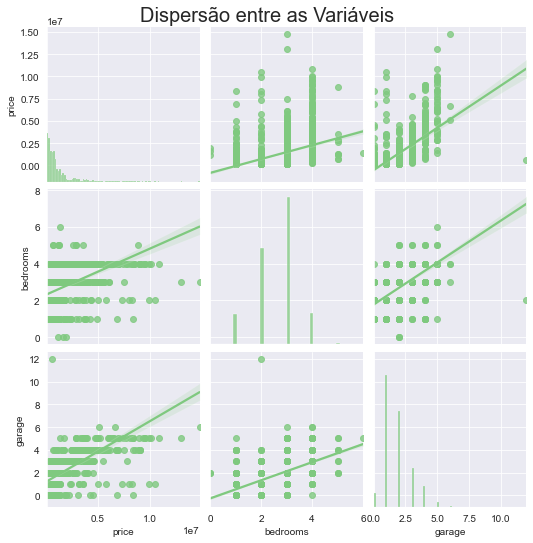

In [54]:
ax = sns.pairplot(df, kind='reg')
ax.fig.suptitle('Dispersão entre as Variáveis', fontsize=20, y=1)
ax

### Exclusão de outlier da coluna garage

In [101]:
df = df.drop(df[(df.garage>10)].index)

In [102]:
df.garage.describe()

count    2365.000000
mean        1.797886
std         1.068189
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: garage, dtype: float64

# Pré-processamento dos dados

## Distribuição de frequências

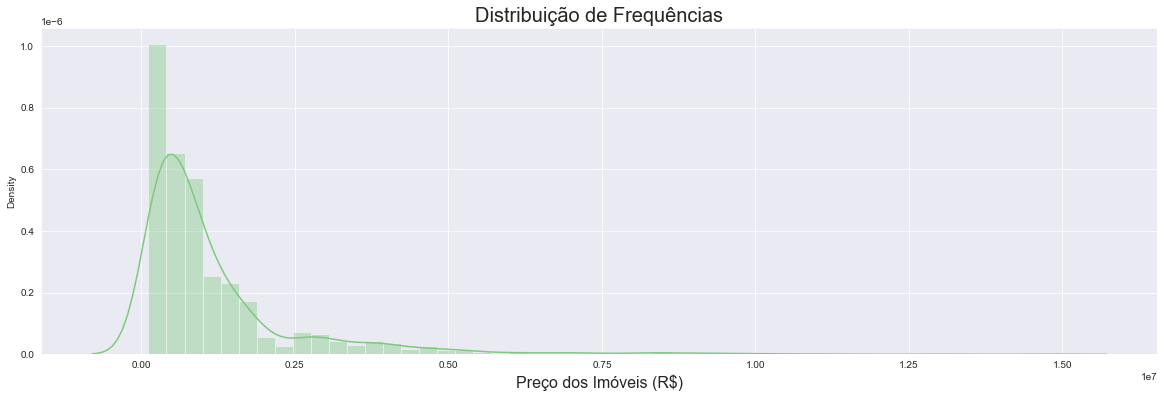

In [103]:
# distribuição de frequências da variável dependente
ax = sns.distplot(df['price'])
ax.figure.set_size_inches(20, 6)
ax.set_title('Distribuição de Frequências', fontsize=20)
ax.set_xlabel('Preço dos Imóveis (R$)', fontsize=16)
ax;

A distribuição de frequência da variável dependente revela uma assimetria à direita.

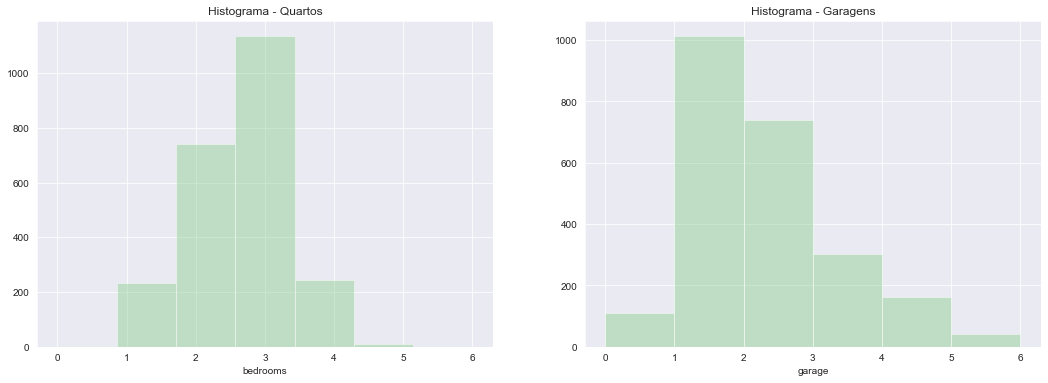

In [105]:
# distribuição de frequências das variáveis independente
plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
sns.distplot(df['bedrooms'], bins=7, kde=False)
plt.title('Histograma - Quartos')

plt.subplot(1, 2, 2)
sns.distplot(df['garage'], bins=6, kde=False)
plt.title('Histograma - Garagens');

### Aplicação da transformação logarítmica aos dados do dataset

In [106]:
df['log_price'] = np.log(df['price'])
df['log_bedrooms'] = np.log(df['bedrooms'] + 1)
df['log_garage'] = np.log(df['garage'] + 1)

In [107]:
df.head()

,price,city,neighborhood,bedrooms,garage,class,region,log_price,log_bedrooms,log_garage
0,194000,curitiba,santa cândida,2,1.0,low,boa vista,12.175613,1.098612,0.693147
1,3850000,curitiba,ecoville,4,4.0,high,santa felicidade,15.163584,1.609438,1.609438
2,2745000,curitiba,ecoville,3,4.0,high,santa felicidade,14.825292,1.386294,1.609438
3,3032000,curitiba,ecoville,3,4.0,high,santa felicidade,14.924733,1.386294,1.609438
4,1640000,curitiba,champagnat,3,3.0,high,matriz,14.310207,1.386294,1.386294


In [108]:
df.describe().round(2)

,price,bedrooms,garage,log_price,log_bedrooms,log_garage
count,2365.00,2365.00,2365.00,2365.00,2365.00,2365.00
mean,1186418.13,2.60,1.80,13.51,1.25,0.96
std,1451481.71,0.82,1.07,0.94,0.25,0.38
min,114950.00,0.00,0.00,11.65,0.00,0.00
25%,350000.00,2.00,1.00,12.77,1.10,0.69
50%,730000.00,3.00,2.00,13.50,1.39,1.10
75%,1350000.00,3.00,2.00,14.12,1.39,1.10
max,14795400.00,6.00,6.00,16.51,1.95,1.95


### Distribuilção de frequências de variáveis transformadas

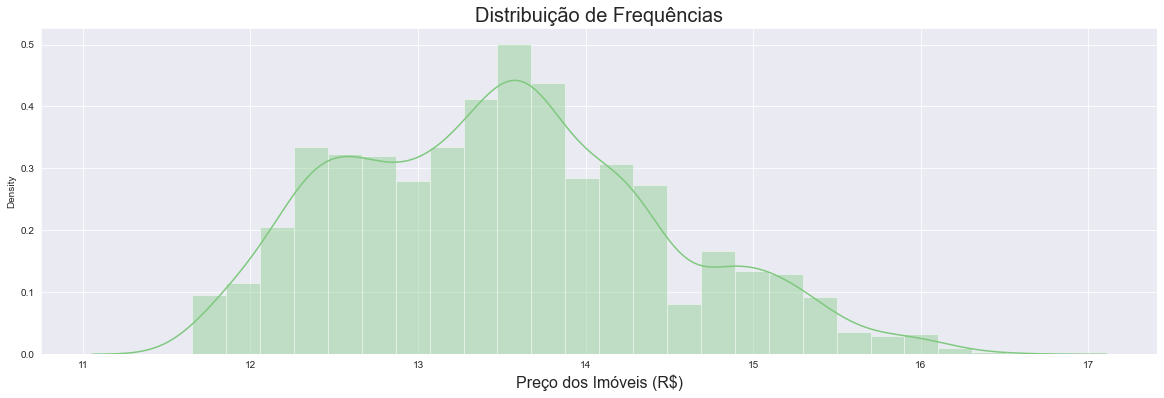

In [109]:
# distribuição de frequências da variável dependente transformada (y)
ax = sns.distplot(df['log_price'])
ax.figure.set_size_inches(20, 6)
ax.set_title('Distribuição de Frequências', fontsize=20)
ax.set_xlabel('Preço dos Imóveis (R$)', fontsize=16)
ax;

### Verificando relação linear entre VD e VI's

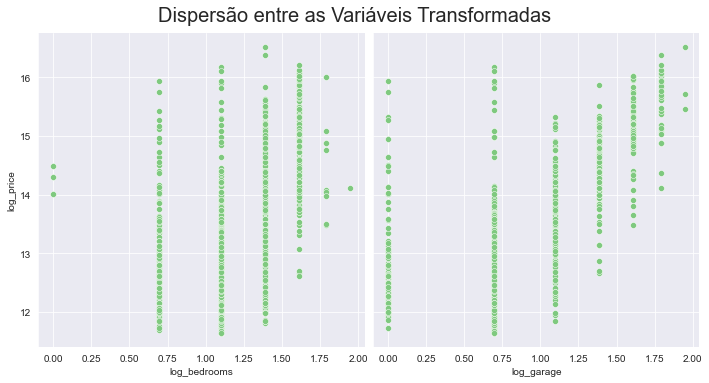

In [110]:
ax = sns.pairplot(df,
                  y_vars='log_price',
                  x_vars=['log_bedrooms', 'log_garage'],
                  height=5)
ax.fig.suptitle('Dispersão entre as Variáveis Transformadas',
                fontsize=20, y=1.05)
ax;

# Estimando um Modelo de Regressão Linear para o Preço

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm

In [112]:
# criação de dataset de treino e teste
y = df['log_price']
X = df[['log_bedrooms', 'log_garage']]

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)

In [125]:
X_train_constant = sm.add_constant(X_train)

model_statsmodels = sm.OLS(y_train, X_train_com_constante, hasconst = True).fit()

In [126]:
print(model_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     1270.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:20:06   Log-Likelihood:                -1765.6
No. Observations:                1892   AIC:                             3537.
Df Residuals:                    1889   BIC:                             3554.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.3665      0.072    157.927   

In [127]:
# criação da função de one-hot encoder
def one_hot_encoder(dataset, columns, drop_first=False):
    dataset = pd.get_dummies(dataset, 
                             columns=columns,
                             drop_first=drop_first)
    return dataset

In [136]:
# transformação das variáveis categóricas
df = one_hot_encoder(df, 
                     ['region'], 
                     drop_first=False)
df

,price,city,neighborhood,bedrooms,garage,class,log_price,log_bedrooms,log_garage,region_bairro novo,region_boa vista,region_boqueirao,region_cajuru,region_cic,region_matriz,region_pinheirinho,region_portao,region_santa felicidade
0,194000,curitiba,santa cândida,2,1.0,low,12.175613,1.098612,0.693147,0,1,0,0,0,0,0,0,0
1,3850000,curitiba,ecoville,4,4.0,high,15.163584,1.609438,1.609438,0,0,0,0,0,0,0,0,1
2,2745000,curitiba,ecoville,3,4.0,high,14.825292,1.386294,1.609438,0,0,0,0,0,0,0,0,1
3,3032000,curitiba,ecoville,3,4.0,high,14.924733,1.386294,1.609438,0,0,0,0,0,0,0,0,1
4,1640000,curitiba,champagnat,3,3.0,high,14.310207,1.386294,1.386294,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2361,585000,curitiba,são francisco,2,2.0,low,13.279367,1.098612,1.098612,0,0,0,0,0,1,0,0,0
2362,1050000,curitiba,água verde,3,2.0,high,13.864301,1.386294,1.098612,0,0,0,0,0,0,0,1,0
2363,1271328,curitiba,mercês,3,2.0,high,14.055573,1.386294,1.098612,0,0,0,0,0,1,0,0,0
2364,3350000,curitiba,cabral,4,5.0,high,15.024471,1.609438,1.791759,0,0,0,0,0,1,0,0,0


In [138]:
df_final = df.drop(columns=['price', 'city', 'neighborhood',
                            'bedrooms', 'garage', 'class'])
df_final.head()

,log_price,log_bedrooms,log_garage,region_bairro novo,region_boa vista,region_boqueirao,region_cajuru,region_cic,region_matriz,region_pinheirinho,region_portao,region_santa felicidade
0,12.175613,1.098612,0.693147,0,1,0,0,0,0,0,0,0
1,15.163584,1.609438,1.609438,0,0,0,0,0,0,0,0,1
2,14.825292,1.386294,1.609438,0,0,0,0,0,0,0,0,1
3,14.924733,1.386294,1.609438,0,0,0,0,0,0,0,0,1
4,14.310207,1.386294,1.386294,0,0,0,0,0,1,0,0,0


In [139]:
# criação de dataset de treino e teste
y = df_final['log_price']
X = df_final.drop(columns=['log_price'])

In [140]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)

X_train_constant = sm.add_constant(X_train)

model_statsmodels = sm.OLS(y_train, X_train_com_constante, hasconst = True).fit()

print(model_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     1270.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:34:59   Log-Likelihood:                -1765.6
No. Observations:                1892   AIC:                             3537.
Df Residuals:                    1889   BIC:                             3554.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.3665      0.072    157.927   

In [142]:
model = LinearRegression()

In [143]:
model.fit(X_train, y_train)

LinearRegression()

In [144]:
print('R² = {}'.format(model.score(X_train, y_train).round(3)))

R² = 0.653


In [145]:
y_previsto = model.predict(X_test)

In [146]:
print('R² = %s' % metrics.r2_score(y_test, y_previsto).round(3))

R² = 0.672


In [148]:
model.intercept_

11.147008364172116

In [149]:
np.exp(model.intercept_)

69356.02944215207

In [150]:
model.coef_

array([ 0.43689081,  1.49839324, -0.73575251,  0.06630711, -0.33099431,
       -0.43092562,  0.1564534 ,  0.5927897 , -0.18623528,  0.26943574,
        0.59892177])

In [151]:
X.columns

Index(['log_bedrooms', 'log_garage', 'region_bairro novo', 'region_boa vista',
       'region_boqueirao', 'region_cajuru', 'region_cic', 'region_matriz',
       'region_pinheirinho', 'region_portao', 'region_santa felicidade'],
      dtype='object')

In [152]:
index = ['Intercepto', 'log_bedrooms', 'log_garage', 'region_bairro novo', 'region_boa vista',
       'region_boqueirao', 'region_cajuru', 'region_cic', 'region_matriz',
       'region_pinheirinho', 'region_portao', 'region_santa felicidade']

In [153]:
pd.DataFrame(data=np.append(model.intercept_, model.coef_),
            index=index, columns=['Parâmetros'])

,Parâmetros
Intercepto,11.147008
log_bedrooms,0.436891
log_garage,1.498393
region_bairro novo,-0.735753
region_boa vista,0.066307
region_boqueirao,-0.330994
region_cajuru,-0.430926
region_cic,0.156453
region_matriz,0.592790
region_pinheirinho,-0.186235


## Interpretação dos Coeficientes Estimados

<p style='font-size: 20px; line-height: 2; margin: 10px 50px; text-align: justify;'>
<b>Intercepto</b> → Excluindo o efeito das variáveis explicativas ($X_2=X_3=0$) o efeito médio no Preço dos Imóveis seria de <b>R$ 69.356,02
</b> (exp[11.147]).
</p>

<p style='font-size: 20px; line-height: 2; margin: 10px 50px; text-align: justify;'>
<b>Quartos</b> → Mantendo-se o valor das outras variáveis constante, um acréscimo em quartos gera, em média, um acréscimo de <b>0.43%</b> no Preço do Imóvel.
</p>

<p style='font-size: 20px; line-height: 2; margin: 10px 50px; text-align: justify;'>
<b>Garagem</b> →  Mantendo-se o valor das outras variáveis constante, um acréscimo em garagem gera, em média, um acréscimo de <b>1.49%</b> no Preço do Imóvel.
</p>

In [154]:
y_previsto_train = model.predict(X_train)

<AxesSubplot:title={'center':'Previsão X Real'}, xlabel='log do Preço - Previsão', ylabel='log do Preço - Real'>

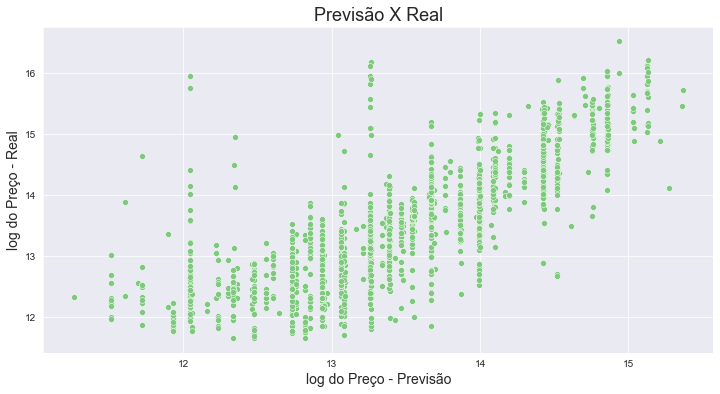

In [155]:
ax = sns.scatterplot(x=y_previsto_train, 
                     y=y_train)
ax.figure.set_size_inches(12, 6)
ax.set_title('Previsão X Real', fontsize=18)
ax.set_xlabel('log do Preço - Previsão', fontsize=14)
ax.set_ylabel('log do Preço - Real', fontsize=14)
ax

In [156]:
residuo = y_train - y_previsto_train

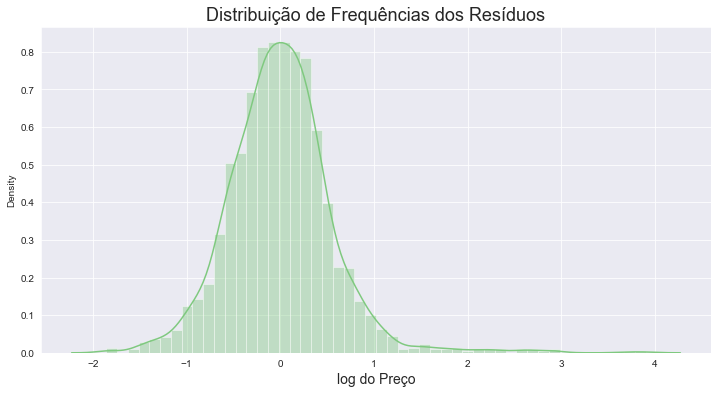

In [157]:
ax = sns.distplot(residuo)
ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de Frequências dos Resíduos', fontsize=18)
ax.set_xlabel('log do Preço', fontsize=14)
ax;